# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [4]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to C:/Users/User/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [189]:
words = Counter()
texts_lengths = []
for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))
    
    text_tokenize = word_tokenize(prccessed_text)
    texts_lengths.append(len(text_tokenize))
    for word in text_tokenize:
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [6]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [7]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [8]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [56]:
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().detach().cpu())
            max_grads.append(p.grad.abs().max().detach().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

#### Базовая модель

In [9]:
class BaseLineModel(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [11]:
model = BaseLineModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [16]:
num_epoch = 20
eval_step_size = 2
eval_steps = len(train_dataloader) // eval_step_size


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = BaseLineModel(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
            
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc


Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/3750 [00:00<?, ?it/s]

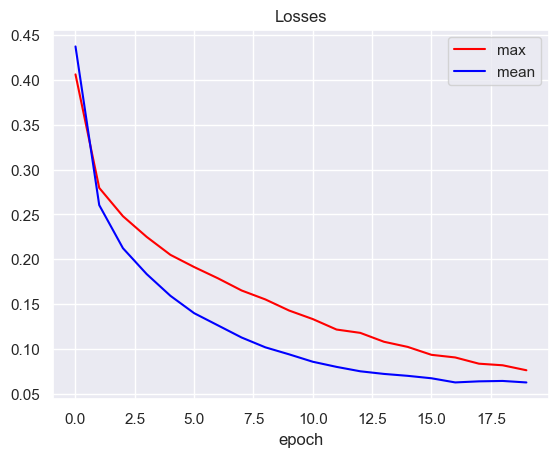

In [17]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.76
Лучшая accuracy для подхода mean: 90.56


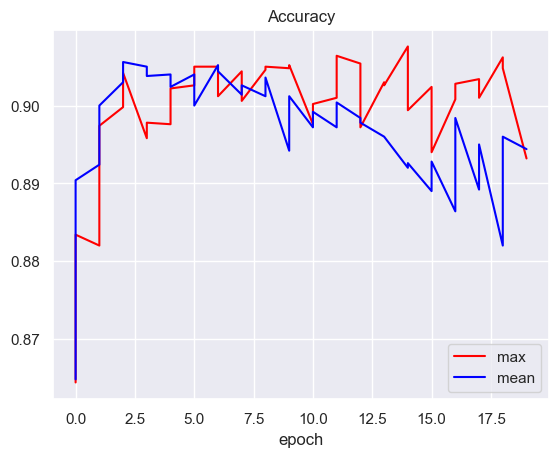

In [37]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:]))//eval_step_size, acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Подитог: подготовка базовой модели
Добавили 4 класса, обучили на 20 эпохах, у базовой модели уже 90,5% точности  
Также можно заметить что 5-10 эпох достаточно, боьлше 10 эпох модель ломается и работает хуже

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

### Простая модель GRU
Просто замена RNN на GRU

In [39]:
class GRUModel(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
#         self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [40]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [41]:
num_epoch = 10
eval_step_size = 2
eval_steps = len(train_dataloader) // eval_step_size


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = GRUModel(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            # Рисуем значения градиентов
            plot_grad_flow(model.named_parameters())

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
            
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc


Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

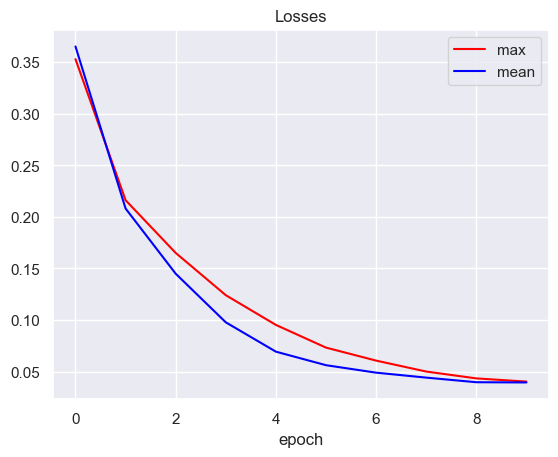

In [42]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.42
Лучшая accuracy для подхода mean: 91.10


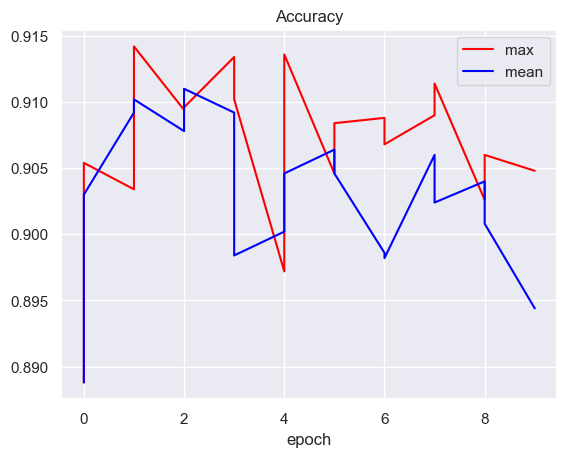

In [43]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:]))//eval_step_size, acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Подитог: простая замена RNN на GRU
Простая замена RNN на GRU повысила точность с 90,5% до 91,4% (для max) и до 91.1% (для mean)

### Модель GRU с большим кол-во слоев
Увеличение количества рекуррентных слоев модели.

In [68]:
class GRUModelPlus(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'mean'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
#         self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(output)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Wall time: 21min 5s


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


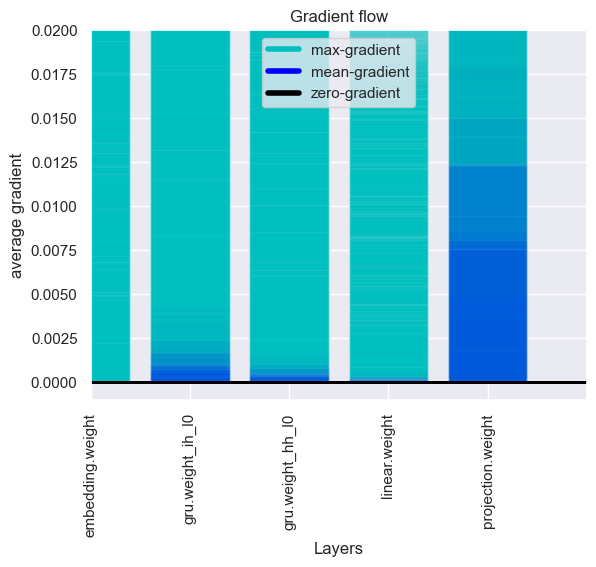

In [70]:
%%time
num_epoch = 5
eval_step_size = 2
eval_steps = len(train_dataloader) // eval_step_size


losses_type = {}
acc_type = {}

# Для более быстрого проведения экспериментов оставляем только один тип агрегации
aggregation_type = "max"
print(f"Starting training for {aggregation_type}")
losses = []
acc = []

model = GRUModelPlus(
    hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):

    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()
#         # Смотрим значения градиентов
#         plot_grad_flow(model.named_parameters())

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

losses_type[aggregation_type] = losses
acc_type[aggregation_type] = acc


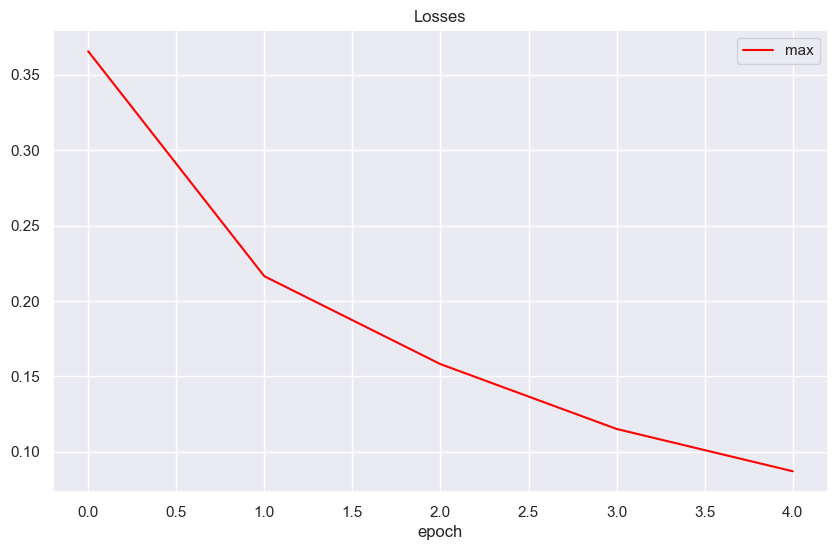

In [73]:
plt.figure(figsize=(10,6))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.46


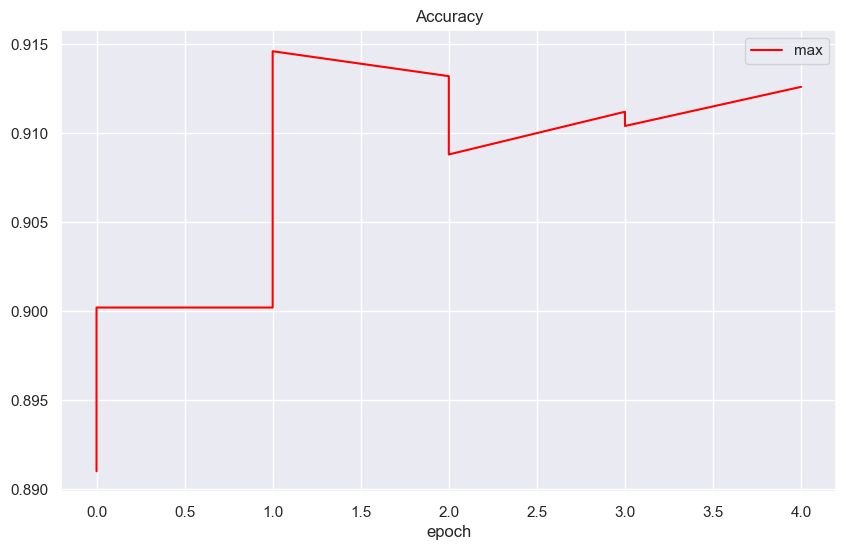

In [74]:
plt.figure(figsize=(10,6))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:]))//eval_step_size, acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Подитог: Два слоя GRU
Просто два слоя GRU не дали сущесвтенного повышения доли правильных ответов (accuracy)
Судя по графику градиентов все норм градиент не исчезает и не вызрывается

### Модель GRU с большим кол-во слоев 2
Увеличение количества рекуррентных слоев модели.

In [88]:
class GRUModelPlus2(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'mean'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
#         self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.non_lin(output)
        output, _ = self.gru(output)  # [batch_size, seq_len, hidden_dim]
        output = self.non_lin(output)
        output, _ = self.gru(output)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [89]:
%%time
num_epoch = 5
eval_step_size = 2
eval_steps = len(train_dataloader) // eval_step_size


losses_type = {}
acc_type = {}

# Для более быстрого проведения экспериментов оставляем только один тип агрегации
aggregation_type = "max"
print(f"Starting training for {aggregation_type}")
losses = []
acc = []

model = GRUModelPlus2(
    hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):

    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

losses_type[aggregation_type] = losses
acc_type[aggregation_type] = acc


Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Wall time: 17min 27s


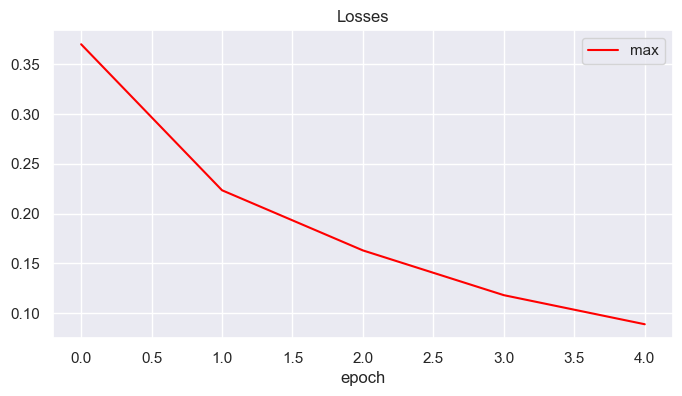

In [93]:
plt.figure(figsize=(8,4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.50


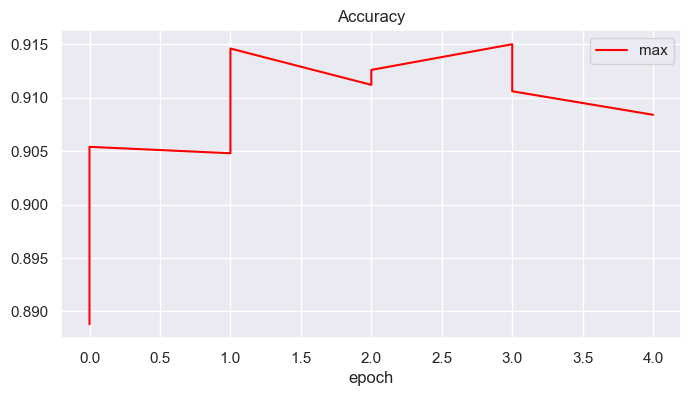

In [94]:
plt.figure(figsize=(8,4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:]))//eval_step_size, acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

###  Один слой LSTM + bidirectional

In [124]:
class LSTM_bidirect_Model(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
#         self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
#         self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.bidirect_LSTM = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.1, bidirectional=True)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
#         output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.bidirect_LSTM(embeddings)  # [batch_size, seq_len, hidden_dim]
        

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [126]:
%%time
num_epoch = 7
eval_step_size = 2
eval_steps = len(train_dataloader) // eval_step_size


losses_type = {}
acc_type = {}

# Для более быстрого проведения экспериментов оставляем только один тип агрегации
aggregation_type = "max"
print(f"Starting training for {aggregation_type}")
losses = []
acc = []

model = LSTM_bidirect_Model(
    hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):

    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

losses_type[aggregation_type] = losses
acc_type[aggregation_type] = acc


Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Wall time: 14min 40s


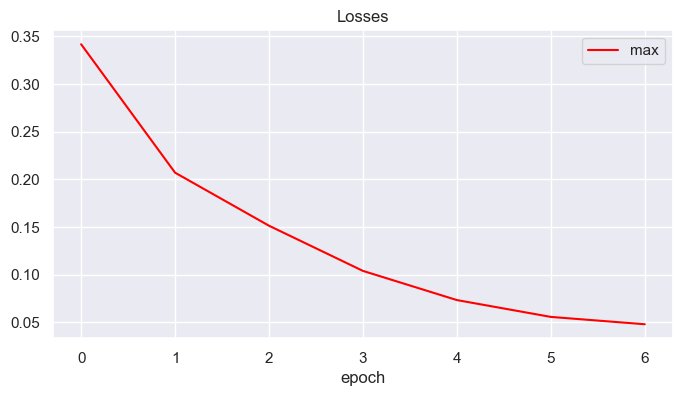

In [127]:
plt.figure(figsize=(8,4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.58


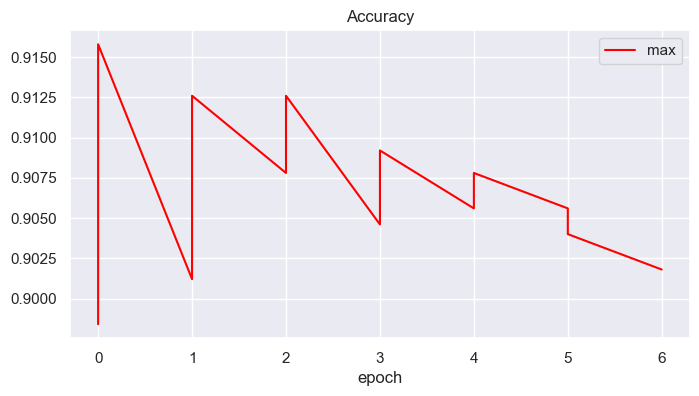

In [128]:
plt.figure(figsize=(8,4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:]))//eval_step_size, acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Подитог: Один слой LSTM + bidirectional
Просто замена 1 слоя GRU на слой LSTM не дала существенного повышения доли правильных ответов (Accuracy = 91.58)


### LSTM + dropout + bidirectional

In [119]:
class LSTM_Model(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'mean'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.LSTM = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.1, bidirectional=False)
        self.bidirect_LSTM = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.1, bidirectional=True)
        self.bidirect_fc = nn.Linear(hidden_dim*2, hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, (hn, cn) = self.LSTM(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.non_lin(output)
        output, (hn, cn) = self.LSTM(output)  # [batch_size, seq_len, hidden_dim]
        output = self.non_lin(output)
        output, (hn, cn) = self.bidirect_LSTM(output)  # [batch_size, seq_len, hidden_dim*2]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.bidirect_fc(self.non_lin(output)))  # hidden_dim*2 -> hidden_dim
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [120]:
%%time
num_epoch = 10
eval_step_size = 2
eval_steps = len(train_dataloader) // eval_step_size


losses_type = {}
acc_type = {}

# Для более быстрого проведения экспериментов оставляем только один тип агрегации
aggregation_type = "max"
print(f"Starting training for {aggregation_type}")
losses = []
acc = []

model = LSTM_Model(
    hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):

    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

losses_type[aggregation_type] = losses
acc_type[aggregation_type] = acc


Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Wall time: 43min


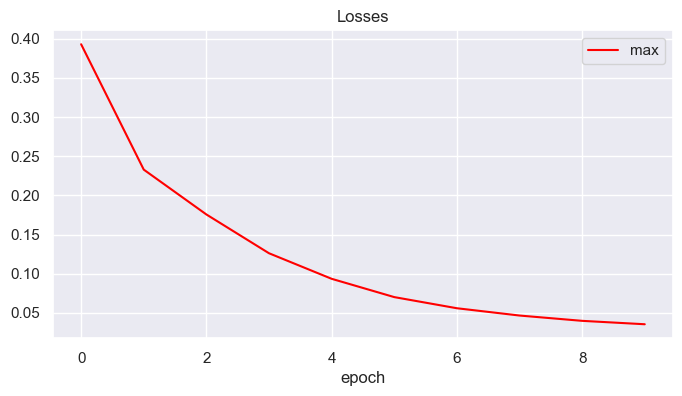

In [121]:
plt.figure(figsize=(8,4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.62


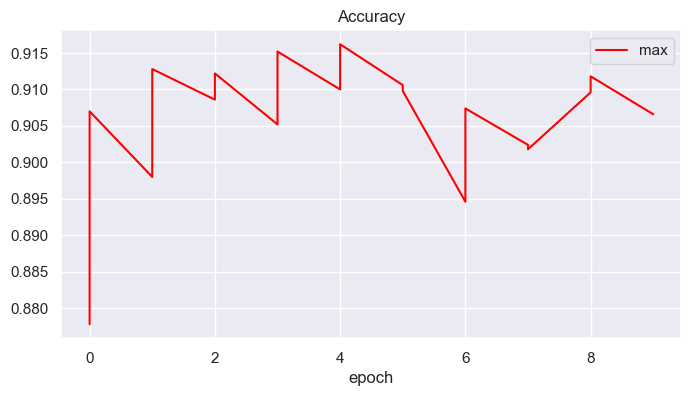

In [122]:
plt.figure(figsize=(8,4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:]))//eval_step_size, acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Подитог: LSTM + dropout + bidirectional
Три слоя LSTM, один из которых двунаправленный не дали сущесвтенного повышения доли правильных ответов (Accuracy = 91.62)


### Изменение архитектуры после применения GRU
Изменение архитектуры после применения GRU. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.

In [169]:
class GRU_Cat_Model(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4, aggregation_type: str = 'mean'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_lower = nn.Linear(hidden_dim*2, hidden_dim)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]
        
        if self.aggregation_type == 'max':
            agg_output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            agg_output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        
        output = self.dropout(self.linear(self.non_lin(agg_output)))  # [batch_size, hidden_dim]
        output = torch.cat((output, agg_output), dim=1)
        output = self.dropout(self.linear_lower(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]
        return prediction

In [170]:
%%time
num_epoch = 7
eval_step_size = 2
eval_steps = len(train_dataloader) // eval_step_size


losses_type = {}
acc_type = {}

# Для более быстрого проведения экспериментов оставляем только один тип агрегации
aggregation_type = "max"
print(f"Starting training for {aggregation_type}")
losses = []
acc = []

model = GRU_Cat_Model(
    hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):

    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()
        # Смотрим значения градиентов
#         plot_grad_flow(model.named_parameters())

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

losses_type[aggregation_type] = losses
acc_type[aggregation_type] = acc


Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Wall time: 13min 50s


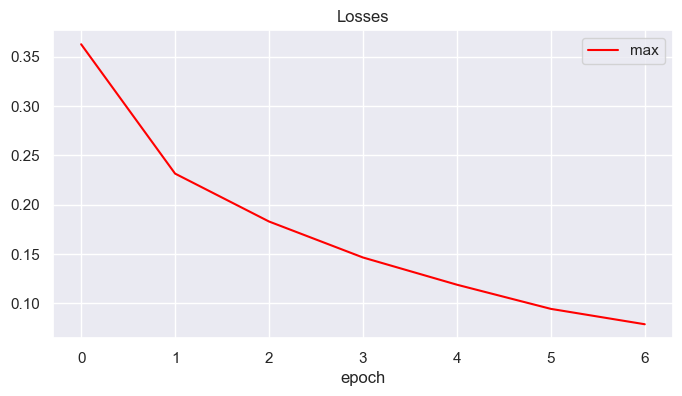

In [171]:
plt.figure(figsize=(8,4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.58


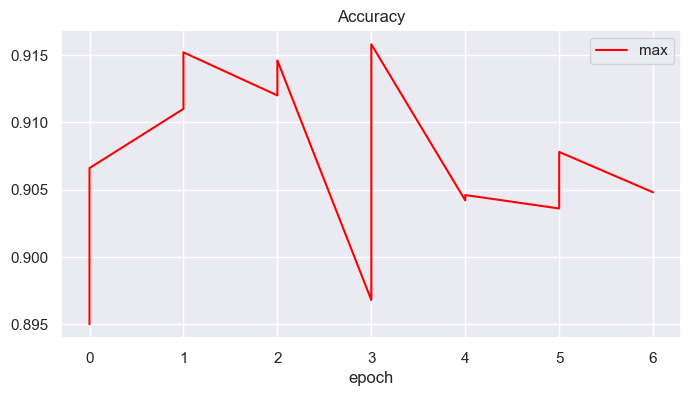

In [172]:
plt.figure(figsize=(8,4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:]))//eval_step_size, acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

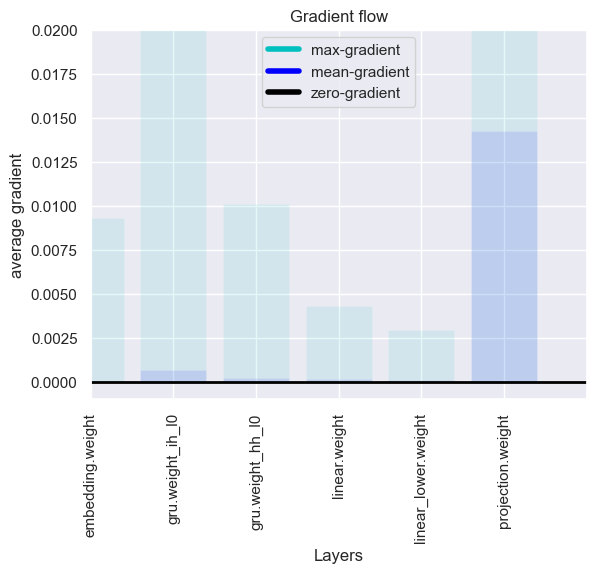

In [173]:
# Смотрим значения градиентов
plot_grad_flow(model.named_parameters())

## Изменение общей архитектуры решения
При слое агрегации по сути теряется довольно много информации. Также агрегация мешает делать такие вещи как skip-connection и прочие манипуляции. 
Попробуем уйти от неё, для этого надо привести к одному размеру все данные. Сейчас приведение к одному размеру через функцию "collate_fn_with_padding" осущесвтляется только в рамках одного батча, но размер у разных батчей разный, давайте сделаем единый размер вообще для всех данных

### Посмотрим расределение размеров текстов
Процент текстов из общего кол-ва с длиной:
- <=40 - 67%  
- <=50 - 93%  
- <=60 - 97%   
- <=70 - 99%  

Оптимальный размер 50-70 - покрывает большую часть текстов  

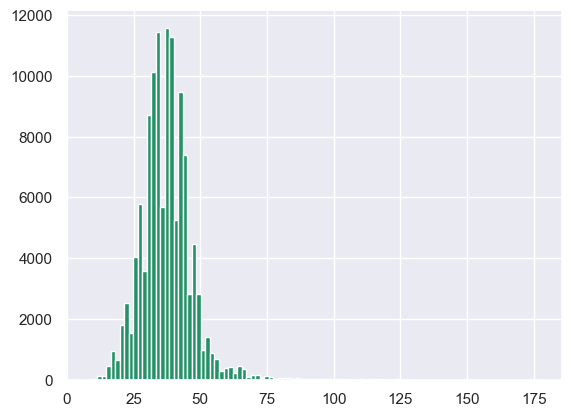

In [191]:
# Расределение размеров текстов
plt.hist(texts_lengths, bins=100)
plt.show() 

In [216]:
print(f"% текстов с длиной <= 40 - {sum(np.where(np.array(texts_lengths)<=40,1,0))*100//len(texts_lengths)}%")
print(f"% текстов с длиной <= 50 - {sum(np.where(np.array(texts_lengths)<=50,1,0))*100//len(texts_lengths)}%")
print(f"% текстов с длиной <= 60 - {sum(np.where(np.array(texts_lengths)<=60,1,0))*100//len(texts_lengths)}%")
print(f"% текстов с длиной <= 70 - {sum(np.where(np.array(texts_lengths)<=70,1,0))*100//len(texts_lengths)}%")

% текстов с длиной <= 40 - 67%
% текстов с длиной <= 50 - 93%
% текстов с длиной <= 60 - 97%
% текстов с длиной <= 70 - 99%


#### Модернизируем функцию приведения всех текстов к единому размеру (предобработка для даталоадера)

In [467]:
# Можернизируем функцию приведения всех текстов к единому размеру (предобработка для даталоадера)
def union_collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], fixlen=70) -> torch.Tensor:
    
    seq_lens = [len(x['text']) for x in input_batch]
    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:fixlen]
        for _ in range(fixlen - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }
    return new_batch

In [468]:
# Обновим даталоадер с новой функцией общего размера
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 64
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=union_collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=union_collate_fn_with_padding, batch_size=batch_size)

#### Архитектурные изменения:  
Агрегация выхода рекурентной сети:  
- либо использовать агрегацию (типа макс, среднее)   
- либо использовать вектор последнего слова в поселдовательности из идеи, что он соедржит инфомрацию всего предложения (эта техника показала плохую точность)  
- либо делать flatten на всех данных (показало более стабильные метрики на эпохах, например агрегация по max/mean имеет боьлший разброс )

In [291]:
class GRU_Cat_Model(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4, aggregation_type: str = 'mean'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_lower = nn.Linear(hidden_dim*2, hidden_dim)
        self.linear_fc = nn.Linear(hidden_dim*50, hidden_dim)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.hidden_dim = hidden_dim
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        
        # Входной слой это [32, 50] размер батча на длину предложения 
        identity = input_batch # [batch_size, seq_len]
        
        # Эмбеддингом переводим каждое слово в векторное представление размером hidden_dim
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # Рекурентная сеть возвращает для каждого слова вектор в новом измерении
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]
        
        # В дальнейшем можно либо использовать агрегацию (типа макс, среднее) 
        #         avg_output = torch.mean(output, 1)
        #         max_output, _ = torch.max(output, 1)        
        # либо использовать вектор последнего слова в поселдовательности из идеи, что он соедржит инфомрацию всего предложения
        #         output = output[:, -1, :] - плохо себя показал
        # либо делать flatten на всех данных
        #         .reshape((1,3,1))
        
        output = output.view(input_batch.shape[0], -1)   # [batch_size, input_batch.shape[1]* hidden_dim]
        output = self.dropout(self.linear_fc(self.non_lin(output)))  # [batch_size, hidden_dim]
        
        # Дополнительный прогон через полносвязанный слой
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]

        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]
        return prediction


In [295]:
%%time
num_epoch = 7
eval_step_size = 2
eval_steps = len(train_dataloader) // eval_step_size


losses_type = {}
acc_type = {}

# Для более быстрого проведения экспериментов оставляем только один тип агрегации
aggregation_type = "max"
print(f"Starting training for {aggregation_type}")
losses = []
acc = []

model = GRU_Cat_Model(
    hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):

    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()
    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f"loss: {losses[-1]}")
    print(f"accuracy_epoch: {acc[-1]}")

losses_type[aggregation_type] = losses
acc_type[aggregation_type] = acc


Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.45998375724057355
accuracy_epoch: 0.8589999675750732


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2766654339124759
accuracy_epoch: 0.889799952507019


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.24037252370069423
accuracy_epoch: 0.8983999490737915


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.21758384960641464
accuracy_epoch: 0.8973999619483948


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2028760828077793
accuracy_epoch: 0.8981999754905701


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.19324210459565122
accuracy_epoch: 0.8989999890327454


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.18599614829172692
accuracy_epoch: 0.899399995803833
Wall time: 11min 28s


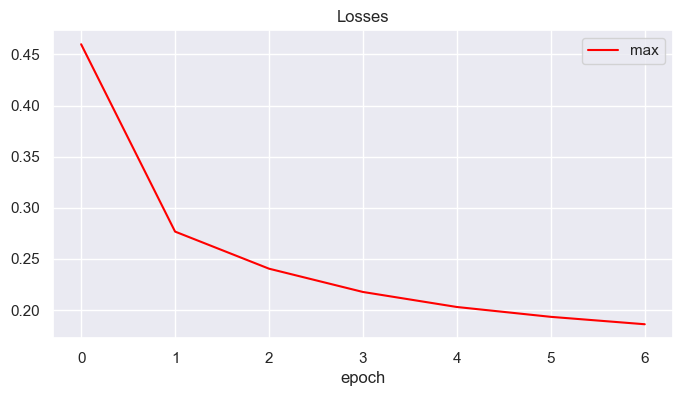

In [296]:
plt.figure(figsize=(8,4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy: 90.00


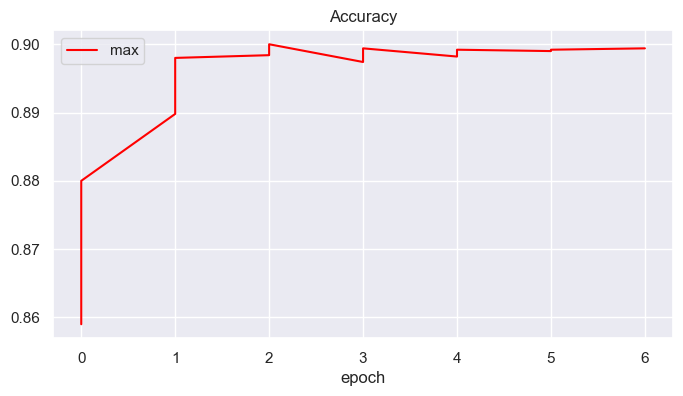

In [298]:
plt.figure(figsize=(8,4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:]))//eval_step_size, acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Архитектурные изменения:  

LSTM считается более мощной чем RNN GRU - будем её использовать  
Настройки рекурентной сети:  
- применим двунаправленный обход
- увеличение слоев LSTM

In [346]:
class LSTM_Model(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4, aggregation_type: str = 'mean'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2, bias=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_lower = nn.Linear(hidden_dim*2, hidden_dim)
        self.linear_fc = nn.Linear(hidden_dim*50*2, hidden_dim)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.hidden_dim = hidden_dim
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        
        # Входной слой это [32, 50] размер батча на длину предложения 
        identity = input_batch # [batch_size, seq_len]
        
        # Эмбеддингом переводим каждое слово в векторное представление размером hidden_dim
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # Рекурентная сеть возвращает для каждого слова вектор в новом измерении
        output, (h_n, c_n) = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = output.reshape(input_batch.shape[0], -1)   # [batch_size, input_batch.shape[1]* hidden_dim]
        output = self.dropout(self.linear_fc(self.non_lin(output)))  # [batch_size, hidden_dim]
        
        # Дополнительный прогон через полносвязанный слой
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]

        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]
        return prediction


In [347]:
%%time
torch.manual_seed(53)
num_epoch = 10
eval_step_size = 2
eval_steps = len(train_dataloader) // eval_step_size


model = LSTM_Model(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

losses_type = {}
acc_type = {}

losses = []
acc = []
for epoch in range(num_epoch):

    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        ## print(f"batch: {batch['input_ids'].shape}")
#         assert False
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()
        # Смотрим значения градиентов
#         plot_grad_flow(model.named_parameters())

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()
    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f"loss epoch: {losses[-1]}")
    print(f"accuracy epoch: {acc[-1]}")

losses_type["flatten"] = losses
acc_type["flatten"] = acc


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.40730390528440474
accuracy epoch: 0.8971999883651733


Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.2458566610435645
accuracy epoch: 0.9097999930381775


Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.19460711805224418
accuracy epoch: 0.9088000059127808


Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.1532741117566824
accuracy epoch: 0.9111999869346619


Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.11954666732499997
accuracy epoch: 0.9139999747276306


Training epoch 5::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.09376651650965213
accuracy epoch: 0.9095999598503113


Training epoch 6::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.07421801306083799
accuracy epoch: 0.9106000065803528
Wall time: 51min 38s


Лучшая accuracy: 91.62


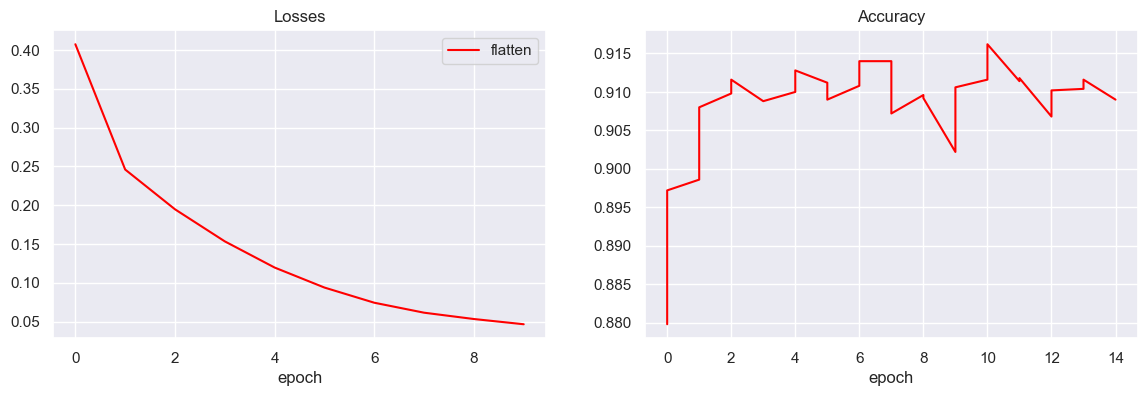

In [351]:
figure, ax = plt.subplots(1, 2, figsize=(14, 4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    ax[0].plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

ax[0].set_title('Losses')
ax[0].set_xlabel("epoch")
ax[0].legend()

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    ax[1].plot(np.arange(len(acc_type[name][1:]))//eval_step_size, acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy: {(max(acc_type[name]) * 100):.2f}")

ax[1].set_title('Accuracy')
ax[1].set_xlabel("epoch")
plt.show()

In [471]:
class LSTM_Model(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4, aggregation_type: str = 'mean'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
#         self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2, bias=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_lower = nn.Linear(hidden_dim*2, hidden_dim)
        self.linear_fc_8_1 = nn.Linear(hidden_dim*8, hidden_dim)
        self.linear_fc = nn.Linear(hidden_dim*70*2, hidden_dim*4)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.hidden_dim = hidden_dim
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        
        # Входной слой это [32, 70] размер батча на длину предложения 
        identity = input_batch # [batch_size, seq_len]
        
        # Эмбеддингом переводим каждое слово в векторное представление размером hidden_dim
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        
        # Рекурентная сеть возвращает для каждого слова вектор в новом измерении
        lstm_output, (h_n, c_n) = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]
        avg_output = torch.mean(lstm_output, 1)
        max_output, _ = torch.max(lstm_output, 1)
        
        lstm_output = lstm_output.reshape(input_batch.shape[0], -1)
        lstm_output = self.dropout(self.linear_fc(self.non_lin(lstm_output)))  # [batch_size, hidden_dim]
        torch.cat((a,b),dim=1)
        output = torch.cat((lstm_output, avg_output, max_output), dim=1)
        
        output = self.dropout(self.linear_fc_8_1(self.non_lin(output)))  # [batch_size, hidden_dim]
        

        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]
        return prediction


In [463]:
%%time
torch.manual_seed(53)
num_epoch = 20
eval_step_size = 2
eval_steps = len(train_dataloader) // eval_step_size


model = LSTM_Model(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

losses_type = {}
acc_type = {}

losses = []
acc = []
for epoch in range(num_epoch):

    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
#         ## L1 regularization
#         l1_lambda = 0.001
#         l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
#         ## L2 regularization
#         l2_lambda = 0.001
#         l2_norm = sum(torch.linalg.norm(p, 2) for p in model.parameters())
#         # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
#         loss = loss + l2_lambda * l2_norm + l1_lambda * l1_norm
    
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()
    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f"loss epoch: {losses[-1]}")
    print(f"accuracy epoch: {acc[-1]}")

losses_type["flatten"] = losses
acc_type["flatten"] = acc


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.39279908680518466
accuracy epoch: 0.8941999673843384


Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.22859853875835737
accuracy epoch: 0.9147999882698059


Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.17284248117407164
accuracy epoch: 0.9157999753952026


Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.12244296532919009
accuracy epoch: 0.91839998960495


Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.08522311685656508
accuracy epoch: 0.9065999984741211


Training epoch 5::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.06224317485230665
accuracy epoch: 0.9079999923706055


Training epoch 6::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.046187794030644
accuracy epoch: 0.9045999646186829


Training epoch 7::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.03701568736421565
accuracy epoch: 0.902999997138977


Training epoch 8::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.030365698254760355
accuracy epoch: 0.9047999978065491


Training epoch 9::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.029953702784283085
accuracy epoch: 0.9077999591827393


Training epoch 10::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.024288592166732997
accuracy epoch: 0.9047999978065491


Training epoch 11::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.023008464422798715
accuracy epoch: 0.9047999978065491


Training epoch 12::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.02006184236725482
accuracy epoch: 0.9065999984741211


Training epoch 13::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.02019062077620377
accuracy epoch: 0.9039999842643738


Training epoch 14::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.01875370595914234
accuracy epoch: 0.9057999849319458


Training epoch 15::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.018390876052210417
accuracy epoch: 0.9035999774932861


Training epoch 16::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.016013792460675663
accuracy epoch: 0.9085999727249146


Training epoch 17::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.017205567630155322
accuracy epoch: 0.9039999842643738


Training epoch 18::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.015920014331536367
accuracy epoch: 0.9037999510765076


Training epoch 19::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.016958239664738844
accuracy epoch: 0.9049999713897705
Wall time: 1h 24min 18s


Лучшая accuracy: 91.84


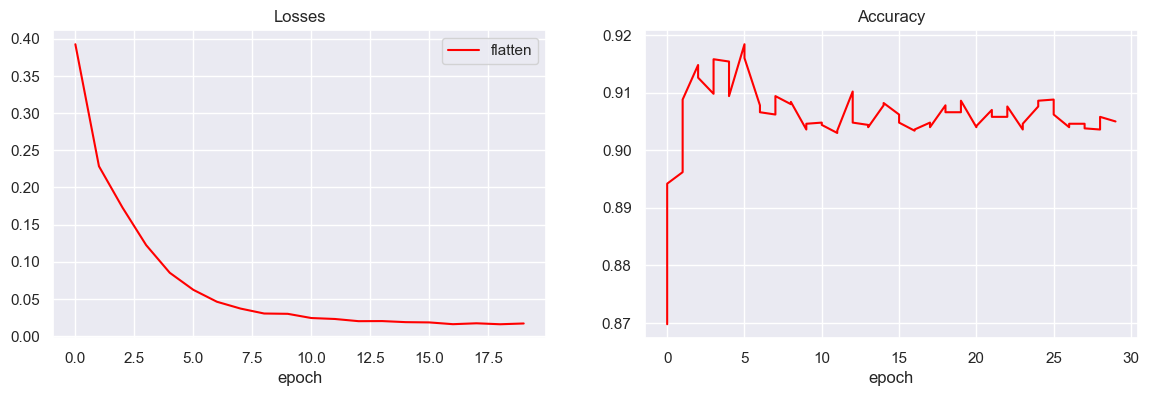

In [464]:
figure, ax = plt.subplots(1, 2, figsize=(14, 4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    ax[0].plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

ax[0].set_title('Losses')
ax[0].set_xlabel("epoch")
ax[0].legend()

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    ax[1].plot(np.arange(len(acc_type[name][1:]))//eval_step_size, acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy: {(max(acc_type[name]) * 100):.2f}")

ax[1].set_title('Accuracy')
ax[1].set_xlabel("epoch")
plt.show()

In [472]:
%%time
torch.manual_seed(53)
num_epoch = 10
eval_step_size = 2
eval_steps = len(train_dataloader) // eval_step_size


model = LSTM_Model(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

losses_type = {}
acc_type = {}

losses = []
acc = []
for epoch in range(num_epoch):

    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
#         ## L1 regularization
#         l1_lambda = 0.001
#         l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
#         ## L2 regularization
#         l2_lambda = 0.001
#         l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
#         loss = loss + l2_lambda * l2_norm + l1_lambda * l1_norm
    
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()
    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f"loss epoch: {losses[-1]}")
    print(f"accuracy epoch: {acc[-1]}")

losses_type["flatten"] = losses
acc_type["flatten"] = acc


Training epoch 0::   0%|          | 0/1875 [00:03<?, ?it/s]

loss epoch: 0.393376200179259
accuracy epoch: 0.8998000025749207


Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.22483468030293782
accuracy epoch: 0.9065999984741211


Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.16835036649107932
accuracy epoch: 0.9133999943733215


Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.12085011315941811
accuracy epoch: 0.9177999496459961


Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.08520204006979863
accuracy epoch: 0.9120000004768372


Training epoch 5::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.05990088415990273
accuracy epoch: 0.9070000052452087


Training epoch 6::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.0448461399160636
accuracy epoch: 0.9073999524116516


Training epoch 7::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.03699902850252887
accuracy epoch: 0.9097999930381775


Training epoch 8::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.03137163726114668
accuracy epoch: 0.9139999747276306


Training epoch 9::   0%|          | 0/1875 [00:00<?, ?it/s]

loss epoch: 0.02670492512889517
accuracy epoch: 0.9052000045776367
Wall time: 56min 44s


Лучшая accuracy: 91.78


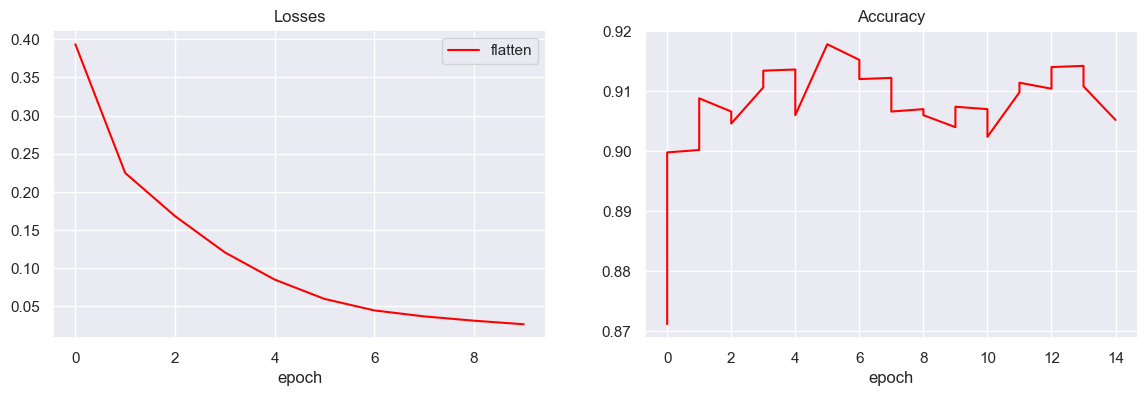

In [473]:
figure, ax = plt.subplots(1, 2, figsize=(14, 4))
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    ax[0].plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

ax[0].set_title('Losses')
ax[0].set_xlabel("epoch")
ax[0].legend()

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    ax[1].plot(np.arange(len(acc_type[name][1:]))//eval_step_size, acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy: {(max(acc_type[name]) * 100):.2f}")

ax[1].set_title('Accuracy')
ax[1].set_xlabel("epoch")
plt.show()

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Итоговая лучшая accuracy: 91.84

## Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

### 1. Результаты экспериментов, какие из них принесли улучшение, а какие нет.

Изменения базовой модели которые повлияли на рост accuracy:  
- Замена RNN на GRU и LSTM  
- настройка гиперпараметров рекурентных слоев  
- учет бидиректа (в обе стороны последовательности)
- отказ от агрегации за счет приведения всех последовательностей к одному размеру, это дало вохможность использовать простой flatten вместо агрегации. Выбран единый размер последовательностей
- объединение результатов рекурентной сети и агрегации среднего, максимального 
- задание параметрами кол-во слоев LSTM
- использование dropout

Выбор размера последовательности. Процент текстов из общего кол-ва с длиной:
- <=40 - 67%  
- <=50 - 93%  
- <=60 - 97%   
- <=70 - 99%  


Эксперименты которые либо никак не повлияли, либо плохо сказались на accuracy:  
- попытка сделать skip-connection для LSTM слоя (т.е. взять входной пакет до LSTM и объединить вместе выходом LSTM)
- добавление L1 и L2 регуляризации 
- использование в качестве агрегации последнего элемента выходной поселдовательности рекурентного слоя (из идеи, что он соедржит инфомрацию всего предложения)
- 


### 2. Графики сходимости моделей в проведенных экспериментах 


Видимо 91,5-92% - это потолок самих данных. При увеличении кол-ва эпох даже при снижении лосса, accuracy все-равно не поднимался выше 91,8:

##### 10 эпох
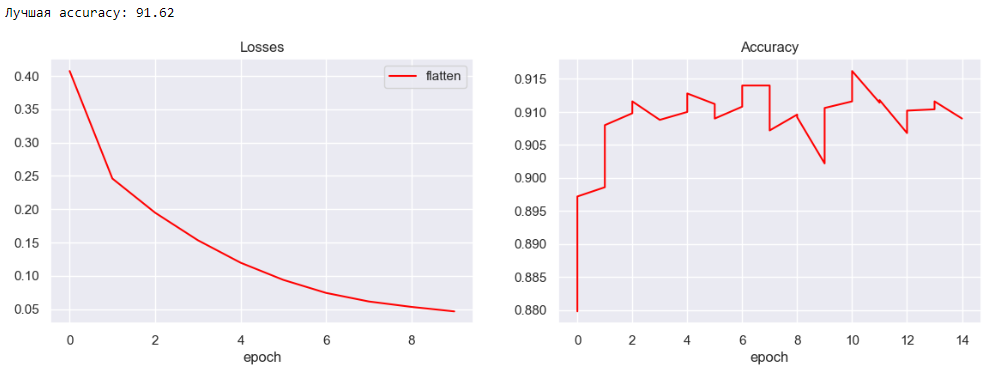

##### 20 эпох (объединение max + mean + flatten выхода LSTM)
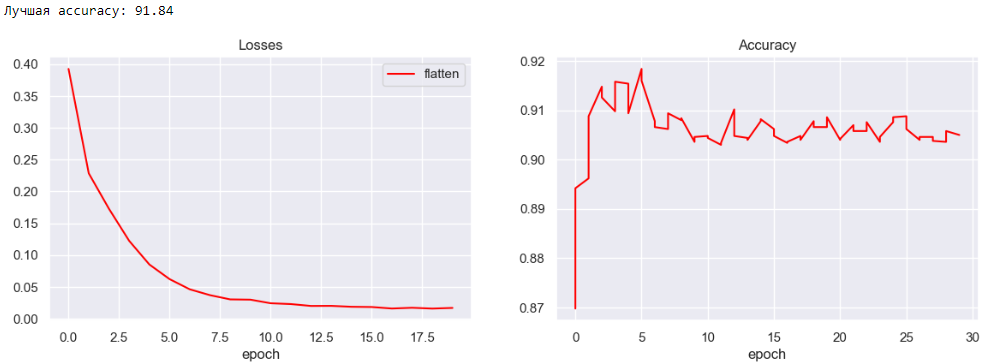


##### 10 эпох (объединение max + mean + flatten выхода LSTM)
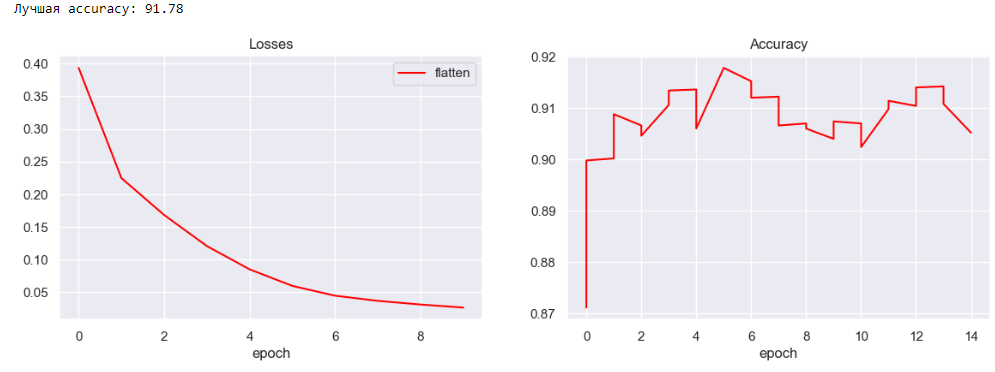

### 3. Какая модель получилась оптимальной.

Оптимальной моделью получилась следующая:
- использование LSTM c двумя слоями + bidirectional (двунаправленный анализ последовательности) + dropout=0.2
- обеспечиене использования в полносвязном слое всех данных от LSTM для этого все последовательности были приведены к одному размеру, это дало вохможность использовать простой flatten вместо агрегаций.
- использование объединения результатов рекурентной сети и агрегации среднего и максимального 



### Возможные пути развития

Данное ДЗ рассчитано на изучение архитектур рекурентных сетей, поэтому все эксперименты проводились вокруг архитектур RNN, GRU, LSTM. Однако если задасться целью повысить качество, то можно попробовать:
1. Использовать предобученные языковые модели
2. Использовать ансамбли, например эмбеддинги предложений использовать в других моделях многоклассовой классификации
3. Сделать feature engineering: вытащить новые фичи, например TF-IDF, n-gram текста или частота встречаемости каждого слова для каждого класса и т.д.